## Spatial wavefield gradient-based seismic wavefield separation

### 04 up/down separation of synthetic OBC data

Up/down separation based on the elastodynamic representation theorem and using spatial wavefield gradients can be applied to OBC data for receiver-side water layer multiple removal. Amundsen et al. (2000) derived analytical expressions for the upgoing horizontal and vertical wavefields that are exact for homogeneous and isotropic media at an infinitesimal distance below the seabed. In order to adapt the up/down separation technique of OBC data to local measurements of the wavefield only, we follow the same approach as for the land seismic case by expanding the filters up to first-order spatial gradients as follows (see Van Renterghem et al. (2018) for details):

$$
v_x^U \approx \frac{1}{2}(v_x + \frac{1}{i\omega}(\alpha - 2\beta)\frac{\partial v_z}{\partial x})
$$

$$
v_y^U \approx \frac{1}{2}(v_y + \frac{1}{i\omega}(\alpha - 2\beta)\frac{\partial v_z}{\partial y})
$$

$$
v_z^U \approx \frac{1}{2}(v_z - \frac{1}{i\omega}(\beta - \frac{2\beta^2}{\alpha})(\frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}) - \frac{1}{\alpha \rho}p)
$$

In this notebook we demonstrate the spatial gradient-based multiple attenuation technique on synthetic finite-difference modelled vertical particle velocity recordings at the seabed. The seismograms (.mat file) were generated from a 2D model consisting of a 100 m thick water layer bounded above by a free-surface. Below the water layer is a homogeneous medium with a P-wave velocity of 1800 m/s, an S-wave velocity of 700 m/s and a density of 1600 kg/m$^{-3}$. An explosive point source emitting a 50 Hz Ricker wavelet was placed at 5 m depth below the sea surface. In order to generate overlapping downgoing and upgoing arrivals recorded by a multicomponent OBC sensor, a second explosive point source was located at 150 m below the seafloor.

In [1]:
# import libraries 
# ----------------
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# check .mat file 
# ---------------
from scipy.io import whosmat
whosmat('OBC_synthetic_data_UD_resample.mat') # to list variables inside mat file

[('vx', (2600, 600), 'double'),
 ('vz', (2600, 600), 'double'),
 ('pressure', (2600, 600), 'double'),
 ('vx_inj', (2600, 600), 'double'),
 ('vz_inj', (2600, 600), 'double'),
 ('pressure_inj', (2600, 600), 'double'),
 ('vx_up', (2600, 600), 'double'),
 ('vz_up', (2600, 600), 'double')]

In [3]:
# load .mat file 
# --------------
from scipy.io import loadmat
mat = loadmat('OBC_synthetic_data_UD_resample.mat')  # to load mat file
# convert them to numpy array
vx = mat['vx']
vz = mat['vz']
vx_inj = mat['vx_inj']
vz_inj = mat['vz_inj']
pressure     = mat['pressure']
pressure_inj = mat['pressure_inj']
mat = 0

In [4]:
# initialize parameter 
# --------------------
nx = vx.shape[1] # number of cells in x direction
dx = 1    # cell size
dt = 1e-4   # time step
alpha = 1800     # P-wave velocity
beta = 700       # S-wave velocity
rho = 1600       # density

In [5]:
# calculate wavefield gradients 
# -----------------------------
from fd_weights import *
c = fd_weights(0, [-3/2, -1/2, 1/2, 3/2], 1) # FD coefficients according to Fornberg (1988)

# allocate zero gradients
gradx_vx = np.zeros((vx.shape[0],nx))
gradx_vz = np.zeros((vx.shape[0],nx))

for n in range(2,(vx.shape[1])-2):
    # horizontal gradients of vx
    gradx_vx[:,n] = ((c[0]*vx[:,n-1]) + (c[1]*vx[:,n])   + (c[2]*vx[:,n+1]) + (c[3]*vx[:,n+2])) / dx
    # horizontal gradients of vz
    gradx_vz[:,n] = ((c[0]*vz[:,n-2]) + (c[1]*vz[:,n-1]) + (c[2]*vz[:,n])   + (c[3]*vz[:,n+1])) / dx

# up/down separation 
# ------------------
# upgoing vx
vx_up       = (1/2.) * (vx + ((alpha*(1 - ((2*beta)/alpha))) * (gradx_vz.cumsum(axis=0)*dt))) 
# upgoing vz
vz_up       = (1/2.) * (vz - (( beta*(1 - ((2*beta)/alpha))) * (gradx_vx.cumsum(axis=0)*dt)) - ((1/(rho*alpha))*pressure)) 
# upgoing pressure
pressure_up = (1/2.) * (pressure - ((alpha * rho) * vz)) 

<IPython.core.display.Javascript object>


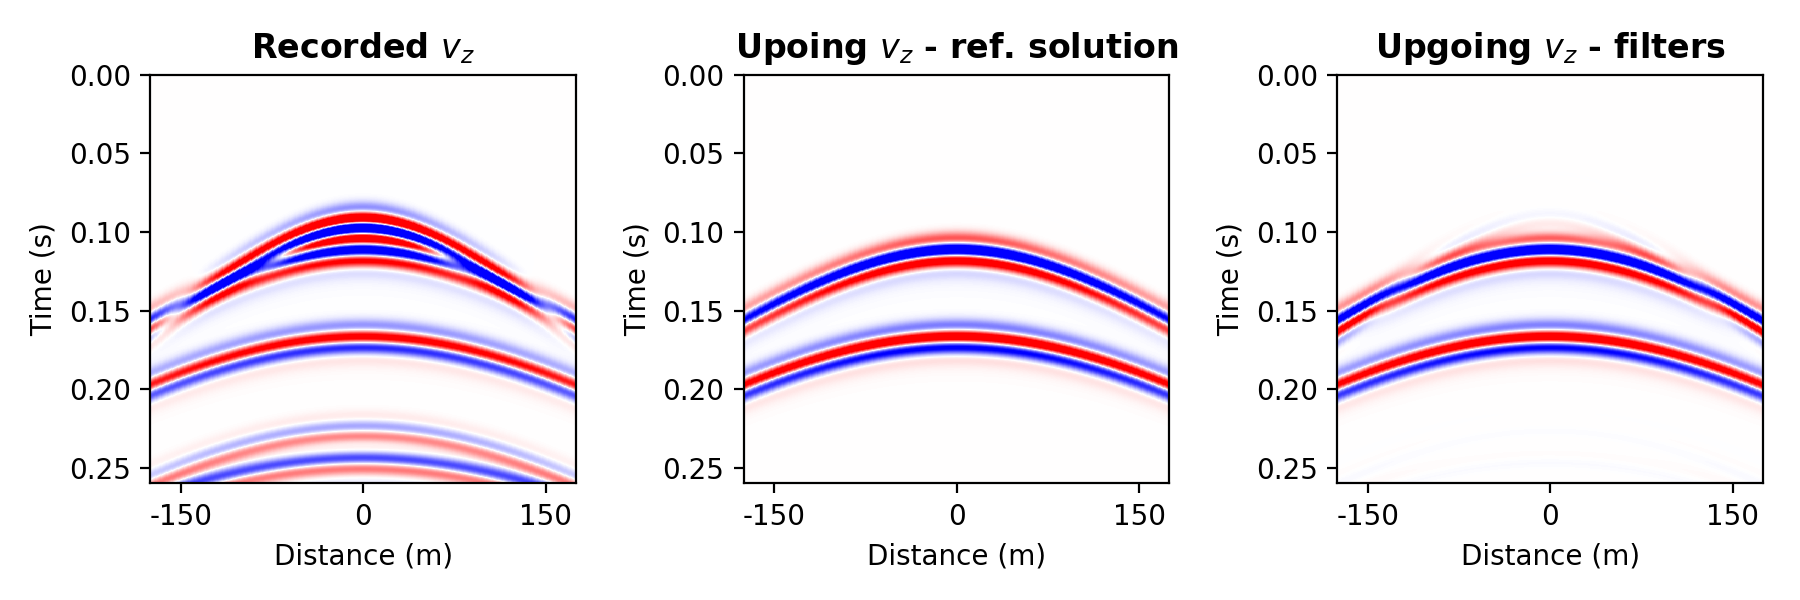

In [6]:
# plotting configuration 
# ----------------------
plt.figure(figsize=(9, 3))

# recorded vz
plt.subplot(1,3,1)
vm1 = np.percentile(vz, 99)
plt.imshow(-vz, cmap="bwr", vmin=-vm1, vmax=vm1, aspect='auto')
plt.xlim(500/4,1900/4)
plt.title('Recorded $v_z$',fontweight="bold")
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.xticks([600/4,1200/4,1800/4],['-150','0','150'])
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20],['0.00','0.05','0.10','0.15','0.20','0.25'])

# upgoing vz - reference solution
plt.subplot(1,3,2)
vm2 = np.percentile(vz_inj, 99)
plt.imshow(-vz_inj, cmap="bwr", vmin=-vm2, vmax=vm2, aspect='auto')
plt.xlim(500/4,1900/4)
plt.title('Upoing $v_z$ - ref. solution',fontweight="bold")
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.xticks([600/4,1200/4,1800/4],['-150','0','150'])          
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20],['0.00','0.05','0.10','0.15','0.20','0.25'])

# upgoing vz - filters
plt.subplot(1,3,3)
vm3 = np.percentile(vz_up, 99)
plt.imshow(-vz_up, cmap="bwr", vmin=-vm3, vmax=vm3, aspect='auto')
plt.xlim(500/4,1900/4)
plt.title('Upgoing $v_z$ - filters',fontweight="bold")
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.xticks([600/4,1200/4,1800/4],['-150','0','150'])
plt.yticks([0,10000/20,20000/20,30000/20,40000/20,50000/20],['0.00','0.05','0.10','0.15','0.20','0.25'])

# show result on screen
plt.tight_layout()
plt.show()

The figures above show the total as well as the reference and estimated upgoing vertical particle velocity recordings. The downgoing direct wave is effectively suppressed, while the upgoing arrivals are preserved, even in case of full overlap of the upgoing and downgoing events as observed at about 100 m offset. The later arriving water layer reverberations are also effectively suppressed.